In [1]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Segmentación

El objetivo principal de esta tarea es segmentar a los clientes en grupos distintos y homogéneos, con el fin de obtener un conocimiento más profundo de nuestra base de clientes y mejorar la estrategia comercial. 

El análisis de los clusters permitirá identificar patrones y características clave de cada grupo, lo que facilitará la orientación de nuestras acciones comerciales de manera más efectiva. Los resultados de esta segmentación se presentarán con una descripción clara y visual de cada cluster, destacando las diferencias entre ellos.

---

Carga de los dataset ya limpios que se encuentran en s3 de AWS, se unen y se genera un nuevo dataset que se guarda en igual en s3 de AWS para su uso directo.

In [2]:

# productos
#prod_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/prod_df_cleaned.parquet") 

# sociodemografico
#sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_cleaned.parquet')

# comercial activity clean
#ca_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df_clean.parquet") 

# merge de los tres dataframes
#df_1_merge = pd.merge(prod_df_cleaned,sdg_df_cleaned, how="inner" ,on=['pk_cid','pk_partition'])

#df_2_merge = pd.merge(df_1_merge,ca_df_cleaned, how="inner",on=['pk_cid','pk_partition'])

#df_full_cleaned = df_2_merge.copy()

#df_full_cleaned.to_parquet("/Users/claudiacastro/df_full_cleaned.parquet")

Este dataset contiene la limpieza y las nuevas columnas creadas en la etapa anterior.

In [3]:
# Cargando los datos directamente de s3 de AWS
df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full_clean = df_full_cleaned.copy()

In [4]:
df_full_clean

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,country_id,region_code,gender,age,deceased,salary,grupo_edad,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,29.0,H,35,N,"87,218.100",Adultos jóvenes,2018-01-12,Otros,1,02 - PARTICULARES
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,13.0,V,23,N,"35,548.740",Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,13.0,V,23,N,"122,179.110",Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,50.0,H,22,N,"119,775.540",Jóvenes,2015-08-10,KHD,0,03 - UNIVERSITARIO
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,V,23,N,"88,419.990",Jóvenes,2015-08-10,KHE,1,03 - UNIVERSITARIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,V,22,N,"43,912.170",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,26.0,V,23,N,"23,334.990",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,H,47,N,"90,123.060",Adultos,2016-08-14,KHE,1,02 - PARTICULARES
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,H,22,N,"199,592.820",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO


# Procedimiento para la segmentación de clientes:

La segmentación de clientes implica agrupar a los clientes en segmentos distintos, cada uno caracterizado por ciertas propiedades que describen su comportamiento y relación con la empresa. Aunque existen innumerables características que podrían utilizarse para este propósito, la elección de las características óptimas depende en gran medida del objetivo comercial que se desee alcanzar con dicha segmentación. Por lo tanto, no existe un único enfoque correcto ni una fórmula universal para llevar a cabo una Segmentación de Clientes.

Las variables seleccionadas para el modelo son fundamentales, ya que definirán las diferencias clave entre los grupos. Para realizar una segmentación efectiva que permita un entendimiento más profundo de nuestra base de clientes y la alineación de nuestras estrategias comerciales, es crucial elegir variables que reflejen el comportamiento del cliente en relación con nuestros productos o servicios. 

1. Técnica de Segmentación: Clustering

Existen varias técnicas de segmentación pero para este caso como el dataset contiene una variedad de variables tanto demográficas como de comportamiento, se realiza la técnica de segmentación basada en Clustering, específicamente K-means, que proporciona una visión holística de los diferentes tipos de clientes.

---
2. Selección de Variables:

Una vez definido la técnica de segmentación, a continuación se definen 3 análisis basados en el clustering que se va a implementar según las diferentes variables presentes: 

Para construir clusters significativos, es crucial elegir variables que reflejen tanto el comportamiento financiero de los clientes como sus características demográficas. Aquí te sugiero una selección de variables que podrías usar, junto con el razonamiento para cada una:

Variables Demográficas:

1.	age (Edad): Es fundamental para entender la etapa de vida en la que se encuentra el cliente, lo que afecta sus necesidades financieras.

2.	country_id (País de residencia): Podría ser útil para identificar variaciones geográficas en el comportamiento de los clientes.
3.	region_code (Provincia): Para segmentar a nivel más granular dentro de un país, especialmente si hay diferencias regionales significativas.
4.  gender (Sexo): Aunque menos relevante en algunos casos, podría influir en la preferencia por ciertos productos financieros.
5.	salary (Ingresos brutos): Indica la capacidad de compra e inversión del cliente, crucial para segmentar en términos de valor potencial.

Variables de Comportamiento Financiero:

1.	active_customer (Actividad del cliente): Indicador de si el cliente está activamente utilizando los productos, importante para identificar clientes leales o en riesgo de abandono.

2.	entry_channel (Canal de captación): Puede influir en el comportamiento inicial y la adopción de productos del cliente.

3.	credit_card, debit_card (Tarjetas de crédito/débito): Reflejan el uso de productos financieros cotidianos y la disposición del cliente a utilizar crédito.
	
4.	em_account_p, em_account_pp, em_acount, emc_account (Cuentas de easyMoney): Estas variables muestran el nivel de compromiso del cliente con los diferentes productos de la empresa, siendo clave para entender la amplitud de su relación con la empresa.
	
5.	loans, mortgage (Préstamos e Hipotecas): Indican el nivel de deuda y el compromiso financiero a largo plazo del cliente.

6.	funds, securities (Fondos y Valores): Reflejan la predisposición del cliente a invertir y su perfil de riesgo.

7.	short_term_deposit, long_term_deposit (Depósitos a corto y largo plazo): Muestran las preferencias del cliente por la seguridad y el rendimiento financiero a corto o largo plazo.

8.	payroll, payroll_account (Domiciliaciones y cuentas bonificadas): Indican el nivel de vinculación del cliente con la empresa a través de la domiciliación de su salario y otros ingresos recurrentes.

9.	pension_plan (Plan de pensiones): Refleja la planificación a largo plazo del cliente y su preocupación por la jubilación.

10. categoria_antiguedad: Muestra la retención del cliente a largo plazo.


---
3. Creación de Nuevas Variables:

   1. Antigüedad del Cliente desde su entry_date. Esto te permite diferenciar entre nuevos clientes y aquellos que han estado más tiempo con la empresa.

   2. Frecuencia de uso de los productos de easyMoney.
	
---
4. Implementación del Clustering:

Preprocesamiento:

	•	Lidiar con valores nulos: Decide cómo manejar valores faltantes (eliminar, imputar, etc.).
	•	Estandarización: Normaliza las variables numéricas para que tengan igual peso en el análisis.

Ejecución del Clustering:

	•	Realiza un análisis de clustering utilizando K-means o Clustering Jerárquico.
	•	Determina el número óptimo de clusters usando técnicas como el método del codo o el análisis de la silueta.

Interpretación de los Clusters:

	•	Analiza cada cluster para entender sus características principales. Por ejemplo, podrías encontrar un grupo de clientes jóvenes con altos ingresos que prefieren productos de inversión, y otro de clientes mayores con preferencias por productos de ahorro a largo plazo.

5. Acciones Comerciales:

Una vez que tengas los clusters, podrás desarrollar estrategias de marketing personalizadas. Por ejemplo:

	•	Clientes Jóvenes con Alto Uso de Crédito: Ofertas de tarjetas de crédito con recompensas.
	•	Clientes Mayores con Depósitos a Largo Plazo: Productos financieros seguros como bonos y certificados de depósito.

Esta estrategia te permitirá aprovechar al máximo los datos disponibles, creando segmentos de clientes con un alto grado de diferenciación y relevancia para tus objetivos comerciales.






---

## Creación de nuevas variables

En el análisis anterior, correspondiente a la Tarea 1 se crearon las siguientes variables en colaboración con el equipo directivo de la empresa:

1. Número Total de Productos Financieros contratados por cliente (num_products_contracts): variable que suma el número de productos financieros que un cliente posee. Esto indica el nivel de compromiso y diversificación en el uso de servicios.


Para la segmentación, se utilizan las variables identificadas en el análisis anterior y se incorporan nuevas variables potencialmente relevantes.

1. Antigüedad del Cliente desde su entry_date. Esto te permite diferenciar entre nuevos clientes y aquellos que han estado más tiempo con la empresa.

2. Frecuencia de uso de los productos de easyMoney.

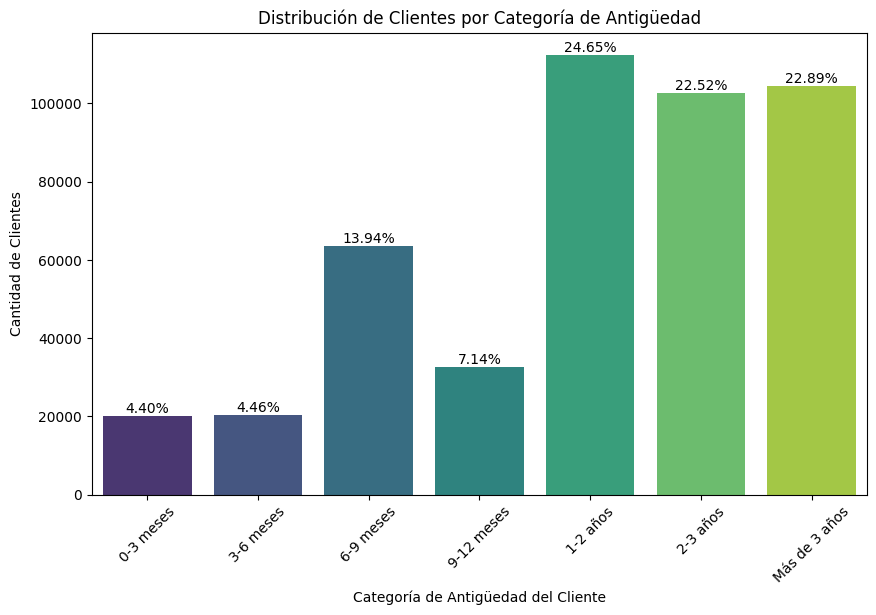